In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import pyplot as plt

import math
import datetime

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

from pylab import rcParams
import statsmodels.api as sm
import statsmodels

import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel("C:/Users/hayrettin.sipar/Desktop/Projeler/Pladis/Bisküvi Talep Tahminleme/Input Data/Sales History/Sales Forecast Data v8.xlsx",
                   sheet_name='Sales_History',header=0)

In [3]:
cal_monthly = pd.read_excel("C:/Users/hayrettin.sipar/Desktop/Projeler/Pladis/Bisküvi Talep Tahminleme/Input Data/Sales History/Sales Forecast Data v8.xlsx",
                   sheet_name='Calendar_Monthly',header=0)

In [4]:
df_all = pd.merge(left=df,right=cal_monthly,left_on='MONTH',right_on='DATE').drop(labels=['Weighteddist','Numericdist','DATE'],axis=1)

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422212 entries, 0 to 422211
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Mkt_Group              422212 non-null  object 
 1   Mkt                    422212 non-null  object 
 2   Prod                   422212 non-null  object 
 3   Mainsegment            422212 non-null  object 
 4   Segment                422212 non-null  object 
 5   Company                422212 non-null  object 
 6   Brand                  422212 non-null  object 
 7   Subbrand               422212 non-null  object 
 8   MONTH                  422212 non-null  object 
 9   Sales_vol              422212 non-null  float64
 10  Sales_val              422212 non-null  float64
 11  Ppv                    422212 non-null  float64
 12  No_of_days             422212 non-null  int64  
 13  Weekdays_n             422212 non-null  int64  
 14  Weekdays_Ratio         422212 non-nu

In [6]:
df_all.MONTH = df_all.MONTH.apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
df_all.index = df_all.MONTH
df_all.rename(columns={'MONTH':'DATE'},inplace=True)

In [7]:
df_all.index = pd.to_datetime(df_all.index)

In [8]:
df_all.index

DatetimeIndex(['2016-12-01', '2016-12-01', '2016-12-01', '2016-12-01',
               '2016-12-01', '2016-12-01', '2016-12-01', '2016-12-01',
               '2016-12-01', '2016-12-01',
               ...
               '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01', '2020-08-01', '2020-08-01',
               '2020-08-01', '2020-08-01'],
              dtype='datetime64[ns]', name='MONTH', length=422212, freq=None)

In [9]:
df_all.sort_values(by=['Mkt_Group','Mkt','Mainsegment','Segment','Company','Brand','Subbrand','DATE'],inplace=True)

In [10]:
df_ulker = df_all[df_all['Company'] == 'ULKER']

In [11]:
agg_func = {'DATE':['max'],'Sales_vol':['sum'],'No_of_days':['max'],'Actual_Holiday_Ratio':['max'],
            'School_Day_Ratio':'max','Ramadan_Ratio':'max','Pandemic':'max'}

df_ulker_agg = df_ulker.groupby('DATE').agg(agg_func)

In [12]:
rename_list = ['DATE','Sales_vol','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']

df_ulker_agg.columns = rename_list

df_ulker_agg['Sales_vol_daily'] = df_ulker_agg.Sales_vol / df_ulker_agg.No_of_days

In [13]:
df_ulker_agg.index = pd.date_range(df_ulker_agg['DATE'].iloc[0], periods=45, freq='M')

In [14]:
df_ulker_agg.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31'],
              dtype='datetime64[ns]', freq='M')

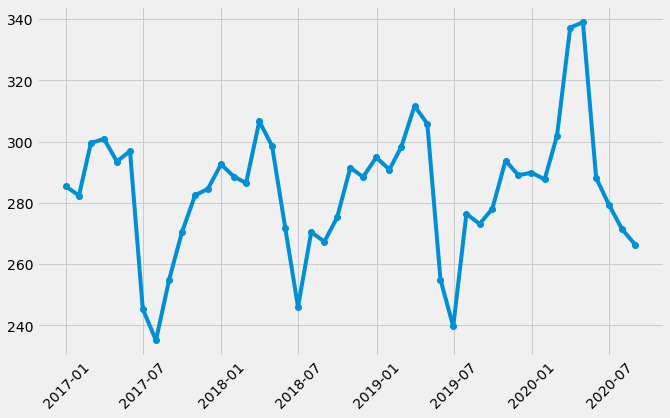

In [15]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.plot(df_ulker_agg['Sales_vol_daily'],marker="o")

In [16]:
cal_tes = cal_monthly[['DATE','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']].copy()

In [17]:
cal_tes.index = cal_tes.DATE
cal_tes.rename(columns={'MONTH':'DATE'},inplace=True)

In [18]:
cal_tes.count()

DATE                    85
No_of_days              85
Actual_Holiday_Ratio    85
School_Day_Ratio        85
Ramadan_Ratio           85
Pandemic                85
dtype: int64

In [19]:
cal_tes.index = pd.to_datetime(cal_tes.index)
cal_tes.index = pd.date_range(cal_tes['DATE'].iloc[0], periods=85, freq='M')

In [20]:
cal_tes.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
      

In [21]:
cal_tes = cal_tes['2020-09-30':'2021-08-31'].copy()
cal_tes['Sales_vol'] = np.NaN
cal_tes['Sales_vol_daily']=np.NaN

col_order= ['DATE','Sales_vol','Sales_vol_daily','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']

cal_tes =  cal_tes[col_order]

In [22]:
cal_tes.index

DatetimeIndex(['2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31'],
              dtype='datetime64[ns]', freq='M')

In [23]:
df_ulker_agg = df_ulker_agg.append(cal_tes).copy()

In [24]:
df_ulker_agg.index = pd.date_range(df_ulker_agg['DATE'].iloc[0], periods=57, freq='M')

In [25]:
df_ulker_agg.drop('DATE',axis=1,inplace=True)

In [26]:
df_ulker_agg.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
      

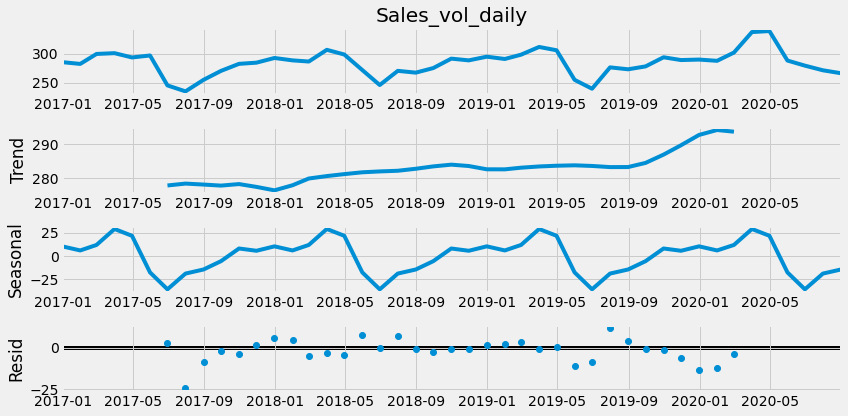

In [27]:
rcParams['figure.figsize'] = 12, 6

decomposition = sm.tsa.seasonal_decompose(df_ulker_agg['Sales_vol_daily'].dropna(),model='additive')
fig = decomposition.plot()

In [28]:
#train_test_split
tr_start,tr_end = '2016-12-31','2020-02-29'
te_start,te_end = '2020-03-31','2021-08-31'

tr_start_pand,tr_end_pand = '2016-12-31','2020-05-31'
te_start_pand,te_end_pand = '2020-06-30','2021-08-31'

tra = df_ulker_agg[tr_start:tr_end]
tes = df_ulker_agg[te_start:te_end]

tra_pand = df_ulker_agg[tr_start_pand:tr_end_pand]
tes_pand = df_ulker_agg[te_start_pand:te_end_pand]

In [29]:
adfres = sm.tsa.adfuller(tra['Sales_vol_daily'],regression='ct')
#adfres2 = sm.tsa.adfuller(tra['Sales_vol'].diff()[1:],regression='ct')

adfres

(-1.9147400514513104,
 0.6469969328041928,
 10,
 28,
 {'1%': -4.3244664923469385,
  '5%': -3.580882474489796,
  '10%': -3.2254187317784258},
 218.60734456644514)

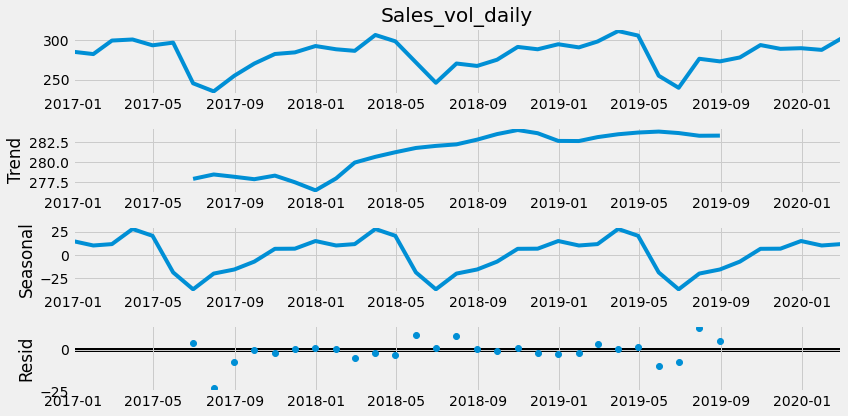

In [30]:
rcParams['figure.figsize'] = 12, 6

decomposition = sm.tsa.seasonal_decompose(tra['Sales_vol_daily'].dropna(),model='additive')
fig = decomposition.plot()

In [31]:
decomposition.trend

2016-12-31           NaN
2017-01-31           NaN
2017-02-28           NaN
2017-03-31           NaN
2017-04-30           NaN
2017-05-31           NaN
2017-06-30    277.900291
2017-07-31    278.453383
2017-08-31    278.163545
2017-09-30    277.859191
2017-10-31    278.310383
2017-11-30    277.477569
2017-12-31    276.460728
2018-01-31    277.960553
2018-02-28    279.949531
2018-03-31    280.669657
2018-04-30    281.246368
2018-05-31    281.784330
2018-06-30    282.042184
2018-07-31    282.235598
2018-08-31    282.827428
2018-09-30    283.525709
2018-10-31    284.035637
2018-11-30    283.636157
2018-12-31    282.667649
2019-01-31    282.652770
2019-02-28    283.143361
2019-03-31    283.502999
2019-04-30    283.720431
2019-05-31    283.840920
2019-06-30    283.655629
2019-07-31    283.315575
2019-08-31    283.333615
2019-09-30           NaN
2019-10-31           NaN
2019-11-30           NaN
2019-12-31           NaN
2020-01-31           NaN
2020-02-29           NaN
Freq: M, Name: trend, dty

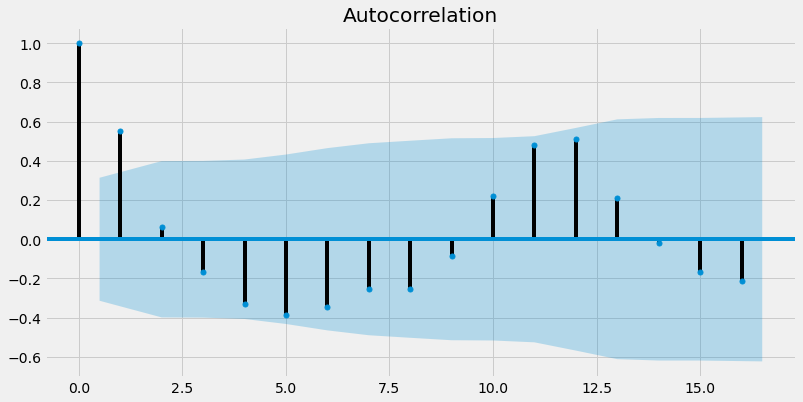

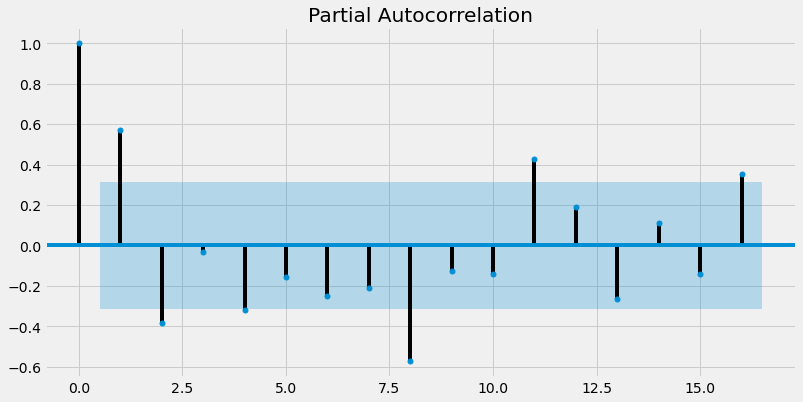

In [32]:
fig = sm.graphics.tsa.plot_acf(tra['Sales_vol_daily'])
fig = sm.graphics.tsa.plot_pacf(tra['Sales_vol_daily'])

In [33]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio']


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tra['Sales_vol_daily'],
                                            tra[regressors],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend='t')

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [34]:
#(0,0,0)x(0,1,2,12) without trend
#(0,1,0)x(2,1,0,12) with trend
#(1,1,1)x(1,0,0,12) with trend
#(2,1,1)x(1,0,0,12) with trend * best model

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio']

mod = sm.tsa.statespace.SARIMAX(tra['Sales_vol_daily'],
                                tra[regressors],
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend='t')

results = mod.fit()

results.summary()

C:\Users\hayrettin.sipar\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Sales_vol_daily   No. Observations:                   39
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                 -78.797
Date:                             Tue, 06 Oct 2020   AIC                            177.594
Time:                                     14:00:40   BIC                            189.375
Sample:                                 12-31-2016   HQIC                           180.720
                                      - 02-29-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
drift                   -0.0004      0.165     -0.002      0.998      -0.324       0.324
No_of_days               2.5667      0.949      2.706      0.007       0.707       4.426
Actual_Holiday_Ratio   -49.6251     10.791     -4.599      0.000     -70.774     -28.476
School_Day_Ratio        39.5193      8.931      4.425      0.000      22.014      57.025
Ramadan_Ratio          -31.7304      8.961     -3.541      0.000     -49.293     -14.168
ar.L1                   -0.2409      0.343     -0.703      0.482      -0.913       0.431
ar.L2                   -0.7681      0.356     -2.157      0.031      -1.466      -0.070
ma.L1                    1.0080      5.781      0.174      0.862     -10.323      12.339
ar.S.L12                 0.0008      0.152      0.005      0.996      -0.296       0.298
sigma2                  36.9602    209.552      0.176      0.860    -373.753     447.674
===================================================================================
Ljung-Box (Q):                       30.53   Jarque-Bera (JB):                10.89
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -1.22
Prob(H) (two-sided):                  0.66   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
results.resid.describe()

count     39.000000
mean       7.955910
std       34.855602
min      -28.234678
25%       -3.556154
50%        1.487560
75%        6.634212
max      192.184047
dtype: float64

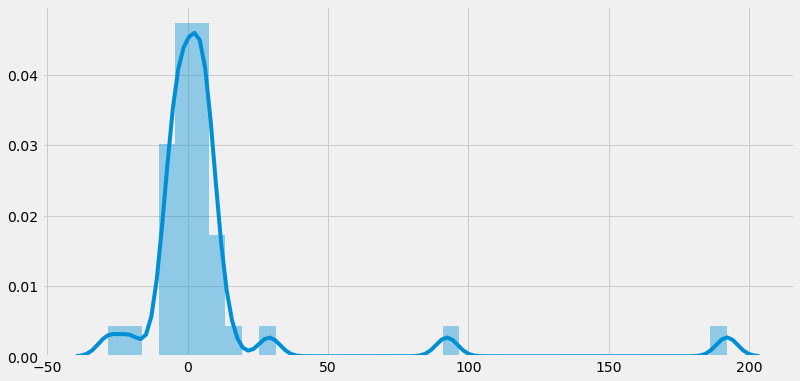

In [36]:
sns.distplot(results.resid)

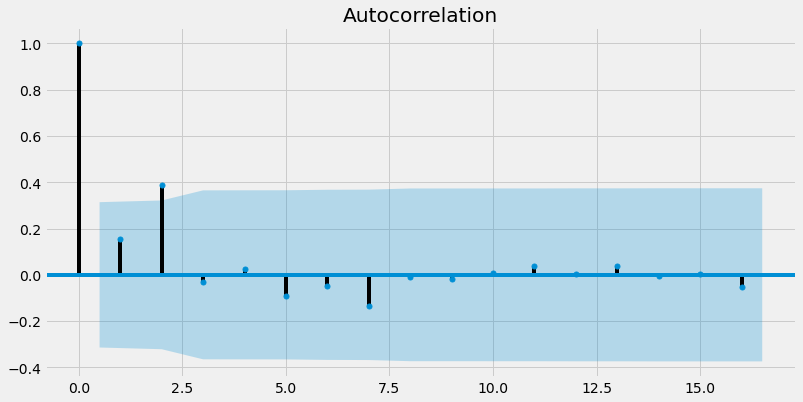

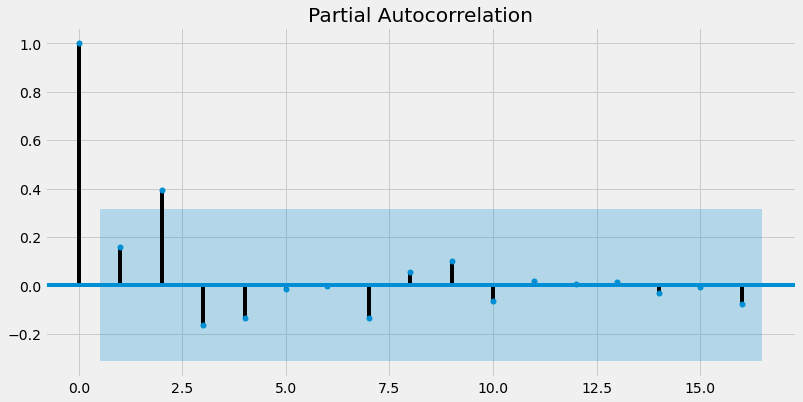

In [37]:
res = results.resid

fig = sm.graphics.tsa.plot_acf(res)
fig = sm.graphics.tsa.plot_pacf(res)

In [38]:
pred = results.predict(start='2017-12-31',end=te_end,exog=tes[regressors])

In [39]:
pred_edt = pred * df_ulker_agg['2017-12-31':]['No_of_days']

In [40]:
prediction = results.get_prediction()
forecast = results.get_forecast(steps=18,exog=tes[regressors])

In [41]:
forecast.conf_int(alpha=0.05)

,lower Sales_vol_daily,upper Sales_vol_daily
2020-03-31,268.802444,293.190953
2020-04-30,230.093168,278.639054
2020-05-31,217.607918,269.739306
2020-06-30,247.278277,300.563843
2020-07-31,234.166844,295.612401
2020-08-31,231.294133,300.575699
2020-09-30,248.359971,319.611123
2020-10-31,258.863548,332.671377
2020-11-30,246.411925,326.247548
2020-12-31,260.313529,344.191901


In [42]:
rms = sqrt(mean_squared_error(df_ulker_agg['2017-12-31':'2020-01-31']['Sales_vol'],pred_edt['2017-12-31':'2020-01-31']))
rms

197.28898843611097

In [43]:
rms = sqrt(mean_squared_error(df_ulker_agg['2020-06-30':'2020-08-31']['Sales_vol'],pred_edt['2020-06-30':'2020-08-31']))
rms

150.0696220470842

In [44]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [45]:
mape(df_ulker_agg['2017-12-31':'2020-01-31']['Sales_vol'],pred_edt['2017-12-31':'2020-01-31'])

1.793441019605886

In [46]:
mape(df_ulker_agg['2020-06-30':'2020-08-31']['Sales_vol'],pred_edt['2020-06-30':'2020-08-31'])

1.4985100303612422

In [47]:
df_ulker_agg

,Sales_vol,No_of_days,Actual_Holiday_Ratio,School_Day_Ratio,Ramadan_Ratio,Pandemic,Sales_vol_daily
2016-12-31,8847.200000,31,0.2903,0.7097,0.0000,0,285.393548
2017-01-31,8753.500000,31,0.2903,0.4839,0.0000,0,282.370968
2017-02-28,8386.700000,28,0.2857,0.6071,0.0000,0,299.525000
2017-03-31,9326.900000,31,0.2581,0.7419,0.0000,0,300.867742
2017-04-30,8804.500000,30,0.3333,0.6667,0.0000,0,293.483333
2017-05-31,9203.200000,31,0.3226,0.6774,0.1613,0,296.877419
2017-06-30,7360.100000,30,0.3333,0.2333,0.8000,0,245.336667
2017-07-31,7287.700000,31,0.3226,0.0000,0.0000,0,235.087097
2017-08-31,7902.700000,31,0.3065,0.0000,0.0000,0,254.925806
2017-09-30,8110.300000,30,0.4167,0.2833,0.0000,0,270.343333


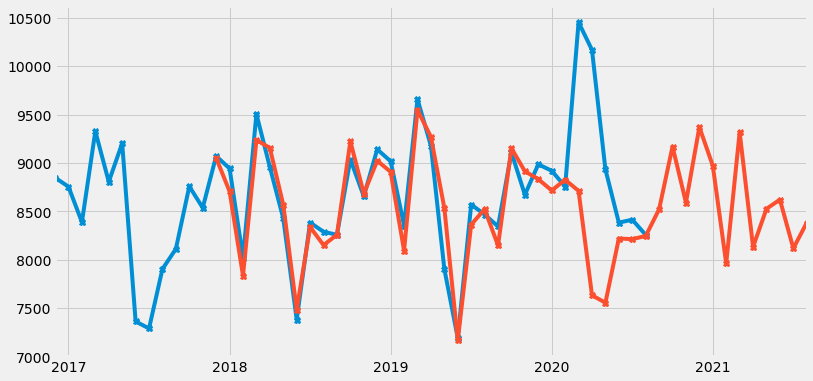

In [48]:
df_ulker_agg['Sales_vol'].plot(marker="X")
pred_edt.plot(marker="X")
#pred.predicted_mean.plot(marker="X")

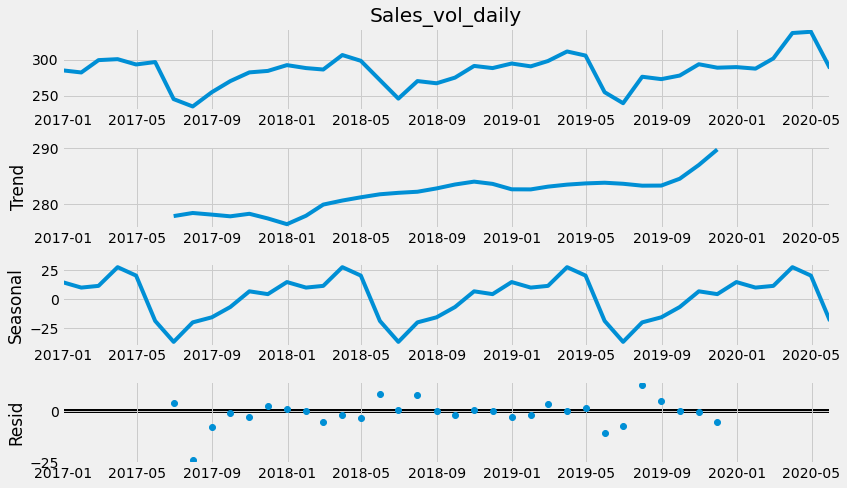

In [49]:
rcParams['figure.figsize'] = 12, 7

decomposition = sm.tsa.seasonal_decompose(tra_pand['Sales_vol_daily'].dropna(),model='additive')
fig = decomposition.plot()

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tra_pand['Sales_vol_daily'],
                                            tra_pand[regressors],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend='t')

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [50]:
#(0, 1, 0)x(1, 0, 0, 12)
#(2, 1, 1)x(1, 0, 0, 12)
#(1, 1, 1)x(1, 0, 0, 12)
#(1, 1, 1)x(1, 0, 0, 12)
#(2, 0, 0)x(1, 1, 0, 12) - Choose
#(2, 1, 1)x(1, 1, 0, 12) - Choose

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']

mod = sm.tsa.statespace.SARIMAX(tra_pand['Sales_vol_daily'],
                                tra_pand[regressors],
                                order=(2, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend='t')

results = mod.fit()

results.summary()

C:\Users\hayrettin.sipar\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    Sales_vol_daily   No. Observations:                   42
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -49.148
Date:                            Tue, 06 Oct 2020   AIC                            118.295
Time:                                    14:00:44   BIC                            126.021
Sample:                                12-31-2016   HQIC                           118.691
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
drift                    0.0053      0.121      0.043      0.965      -0.233       0.243
No_of_days               5.1311     15.931      0.322      0.747     -26.092      36.354
Actual_Holiday_Ratio   -38.8589    108.304     -0.359      0.720    -251.130     173.413
School_Day_Ratio       -21.6460     34.048     -0.636      0.525     -88.379      45.087
Ramadan_Ratio          -20.9422     29.968     -0.699      0.485     -79.679      37.794
Pandemic                19.4292     23.603      0.823      0.410     -26.833      65.691
ar.L1                    0.4451      0.628      0.709      0.479      -0.786       1.677
ar.L2                   -0.1535      0.568     -0.270      0.787      -1.267       0.960
ar.S.L12                 0.1658      0.284      0.583      0.560      -0.391       0.723
sigma2                  27.4651     20.283      1.354      0.176     -12.288      67.218
===================================================================================
Ljung-Box (Q):                       13.29   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.58   Prob(JB):                         0.22
Heteroskedasticity (H):               0.11   Skew:                             0.88
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
results.resid.describe()

count     42.000000
mean      32.267810
std       60.464553
min      -34.418894
25%       -4.360618
50%        0.737882
75%       89.949110
max      152.973508
dtype: float64

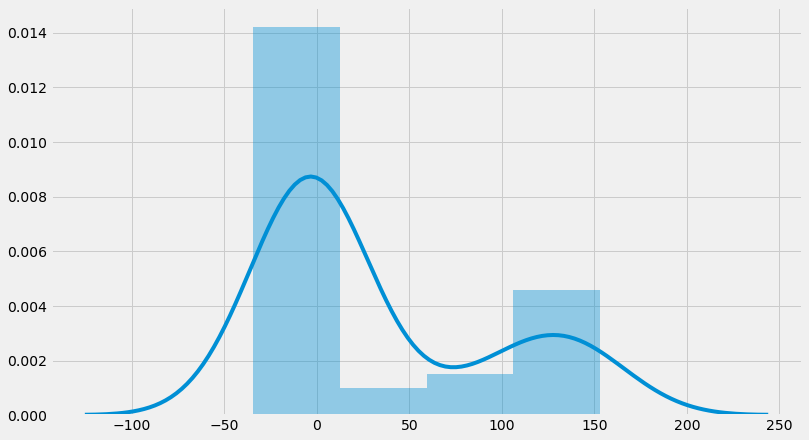

In [52]:
sns.distplot(results.resid)

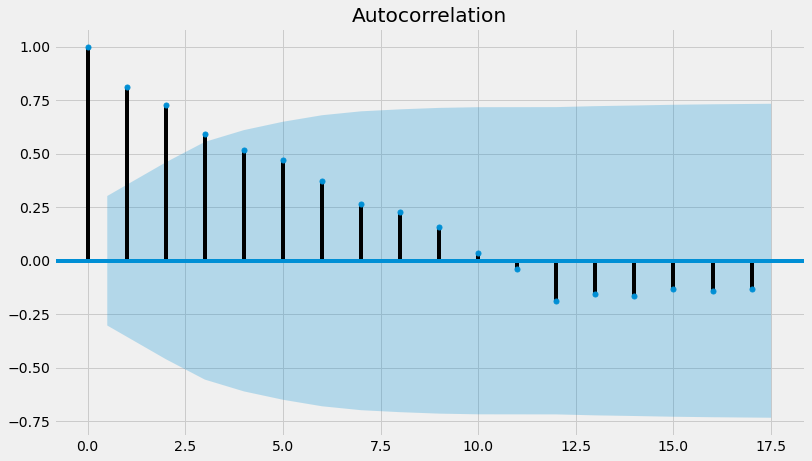

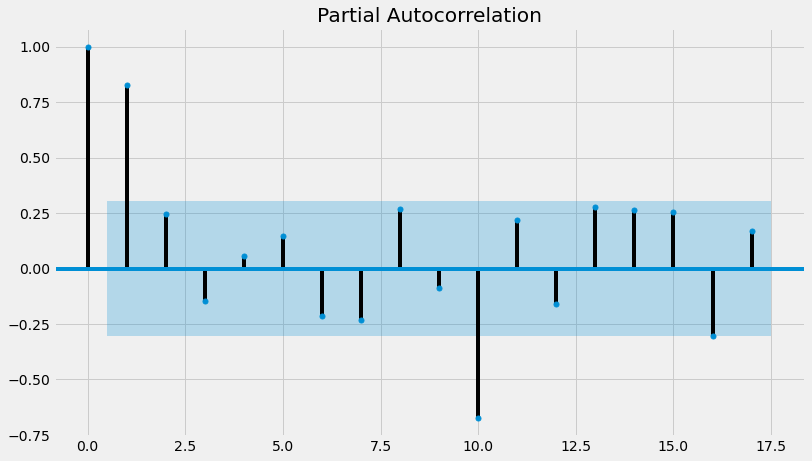

In [53]:
res = results.resid

fig = sm.graphics.tsa.plot_acf(res)
fig = sm.graphics.tsa.plot_pacf(res)

In [54]:
pred_pand = results.predict(start='2018-12-31',end=te_end_pand,exog=tes_pand[regressors])

In [55]:
pred_pand_edt = pred_pand * df_ulker_agg['2018-12-31':]['No_of_days']

In [56]:
pred_pand_edt

2018-12-31     9114.884088
2019-01-31     9006.845450
2019-02-28     7952.547624
2019-03-31     9722.253630
2019-04-30     8996.331382
2019-05-31     8187.439490
2019-06-30     7313.374570
2019-07-31     8485.676711
2019-08-31     8444.867220
2019-09-30     8222.614705
2019-10-31     9117.777200
2019-11-30     8770.386636
2019-12-31     9122.233181
2020-01-31     8986.335368
2020-02-29     8803.411244
2020-03-31    10558.768396
2020-04-30    10069.057861
2020-05-31     8853.128266
2020-06-30     8219.144785
2020-07-31     8553.069963
2020-08-31     8573.791828
2020-09-30     8589.439248
2020-10-31     9117.022498
2020-11-30     8668.529521
2020-12-31     8984.680423
2021-01-31     8767.033193
2021-02-28     8438.151903
2021-03-31     9606.697007
2021-04-30     9036.890222
2021-05-31     8227.334017
2021-06-30     7346.681974
2021-07-31     8417.279519
2021-08-31     8630.394368
Freq: M, dtype: float64

In [57]:
prediction = results.get_prediction()
forecast = results.get_forecast(steps=18,exog=tes[regressors])

In [58]:
forecast.conf_int(aplha=0.05)

,lower Sales_vol_daily,upper Sales_vol_daily
2020-06-30,260.930867,281.474111
2020-07-31,275.578343,298.065051
2020-08-31,265.451929,287.957357
2020-09-30,300.253168,322.780583
2020-10-31,297.144506,319.679484
2020-11-30,292.228773,314.764005
2020-12-31,283.381692,305.916964
2021-01-31,268.325501,290.860800
2021-02-28,299.853311,322.388612
2021-03-31,298.625801,321.161102


In [59]:
rms = sqrt(mean_squared_error(df_ulker_agg['2018-12-31':'2020-05-31']['Sales_vol'],pred_pand_edt['2018-12-31':'2020-05-31']))
rms

144.91197441692427

In [60]:
rms = sqrt(mean_squared_error(df_ulker_agg['2020-06-30':'2020-08-31']['Sales_vol'],pred_pand_edt['2020-06-30':'2020-08-31']))
rms

221.61098710358888

In [61]:
mape(df_ulker_agg['2018-12-31':'2020-05-31']['Sales_vol'],pred_pand_edt['2018-12-31':'2020-05-31'])

1.264061362544717

In [62]:
mape(df_ulker_agg['2020-06-30':'2020-08-31']['Sales_vol'],pred_pand_edt['2020-06-30':'2020-08-31'])

2.488278153462675

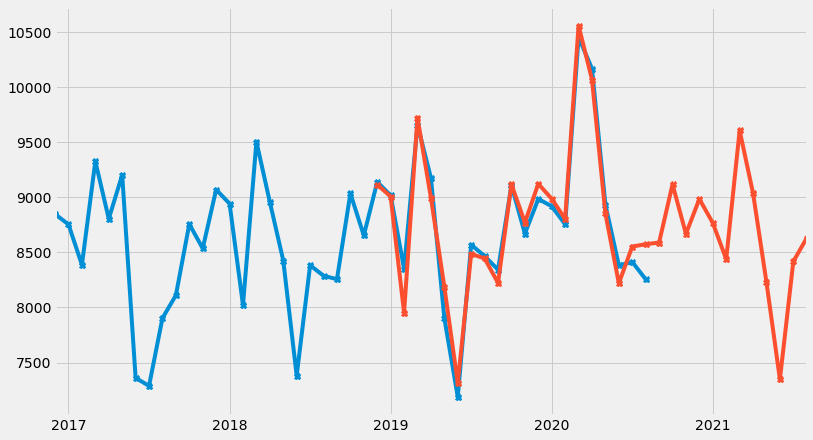

In [63]:
df_ulker_agg['Sales_vol'].plot(marker="X")

pred_pand_edt.plot(marker="X")
#pred.predicted_mean.plot(marker="X")

In [64]:
pred_pand_edt

2018-12-31     9114.884088
2019-01-31     9006.845450
2019-02-28     7952.547624
2019-03-31     9722.253630
2019-04-30     8996.331382
2019-05-31     8187.439490
2019-06-30     7313.374570
2019-07-31     8485.676711
2019-08-31     8444.867220
2019-09-30     8222.614705
2019-10-31     9117.777200
2019-11-30     8770.386636
2019-12-31     9122.233181
2020-01-31     8986.335368
2020-02-29     8803.411244
2020-03-31    10558.768396
2020-04-30    10069.057861
2020-05-31     8853.128266
2020-06-30     8219.144785
2020-07-31     8553.069963
2020-08-31     8573.791828
2020-09-30     8589.439248
2020-10-31     9117.022498
2020-11-30     8668.529521
2020-12-31     8984.680423
2021-01-31     8767.033193
2021-02-28     8438.151903
2021-03-31     9606.697007
2021-04-30     9036.890222
2021-05-31     8227.334017
2021-06-30     7346.681974
2021-07-31     8417.279519
2021-08-31     8630.394368
Freq: M, dtype: float64